# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

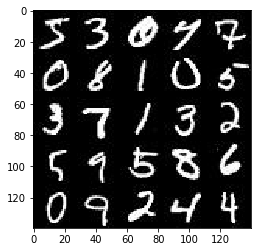

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

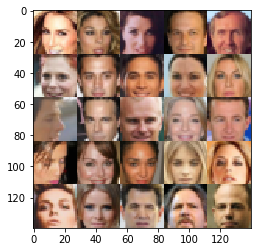

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.6.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input =  tf.placeholder(tf.float32,[None,image_width,image_height,image_channels])
    z_input = tf.placeholder(tf.float32,[None,z_dim])
    learning_rate = tf.placeholder(tf.float32)
    return (real_input,z_input,learning_rate)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.1
    keep_prob = 0.9
    with tf.variable_scope('discriminator',reuse=reuse):
        #14*14*16
        c1 = tf.layers.conv2d(images,16,kernel_size=5,strides=2,padding='same')
        lrel1 = tf.maximum(alpha*c1, c1)
        kp1 = tf.nn.dropout(lrel1,keep_prob=keep_prob)
        
        #7*7*32
        c2 = tf.layers.conv2d(kp1,32,kernel_size=5,strides=2,padding='same')
        bn1 = tf.layers.batch_normalization(c2,training=True)
        lrel2 = tf.maximum(alpha*bn1, bn1)
        kp2 = tf.nn.dropout(lrel2,keep_prob=keep_prob)
        
        #4*4*64
        c3 = tf.layers.conv2d(kp2,64,kernel_size=5,strides=2,padding='same')
        bn2 = tf.layers.batch_normalization(c3,training=True)
        lrel3 = tf.maximum(alpha*bn2, bn2)
        kp3 = tf.nn.dropout(lrel3,keep_prob=keep_prob)
        
        #flattening 
        flat = tf.reshape(kp3,[-1,4*4*64])
        fc1 = tf.layers.dense(flat,1300)
        bn3 = tf.layers.batch_normalization(fc1,training=True)
        lrel4 = tf.maximum(alpha*bn3, bn3)
        kp4 = tf.nn.dropout(lrel4,keep_prob = keep_prob)
        
        #output
        logits = tf.layers.dense(kp4,1)
        out = tf.nn.sigmoid(logits)
    return (out,logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.1
    keep_prob = 0.9
    # TODO: Implement Function
    with tf.variable_scope('generator',reuse=not is_train):
        fc1 = tf.layers.dense(z,7*7*512)
        
        #7*7*512
        c1 = tf.reshape(fc1,[-1,7,7,512])
        bn1 = tf.layers.batch_normalization(c1,training=is_train)
        lrel1 = tf.maximum(alpha*bn1 , bn1)
        
        #14*14*256
        c2 = tf.layers.conv2d_transpose(lrel1,256,kernel_size=5,strides=2,padding='same')
        bn2 = tf.layers.batch_normalization(c2,training=is_train)
        lrel2 = tf.maximum(alpha*bn2, bn2)
        kp1 = tf.nn.dropout(lrel2,keep_prob=keep_prob)
        
        #14*14*128
        c3 = tf.layers.conv2d_transpose(kp1,128,kernel_size=5,strides=1,padding='same')
        bn3 = tf.layers.batch_normalization(c3,training=is_train)
        lrel3 = tf.maximum(alpha*bn3,bn3)
        kp2 = tf.nn.dropout(lrel3,keep_prob=keep_prob)
        
        #28*28*3
        c4 = tf.layers.conv2d_transpose(kp2,out_channel_dim,kernel_size=5,strides=2,padding='same')
        out = tf.nn.tanh(c4)
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1
    g_model = generator(input_z,out_channel_dim,is_train=True)
    d_model_real,d_model_real_logits = discriminator(input_real,reuse=False)
    d_model_fake,d_model_fake_logits = discriminator(g_model,reuse=True)
    

    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_model_real_logits,
                                                                         labels=tf.ones_like(d_model_real_logits) *(1-smooth)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_model_fake_logits,
                                                                        labels=tf.zeros_like(d_model_fake_logits)))
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_model_fake_logits,
                                                                   labels=tf.ones_like(d_model_fake_logits)))
    return (d_loss,g_loss)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_opt = tf.train.AdamOptimizer(learning_rate=learning_rate,beta1=beta1).minimize(d_loss,var_list=d_vars)
        g_opt = tf.train.AdamOptimizer(learning_rate=learning_rate,beta1=beta1).minimize(g_loss,var_list=g_vars)
    return d_opt,g_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [26]:
import numpy as np
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _,image_width,image_height,image_channels = data_shape
    
    # getting placeholders
    input_real,input_z,lr = model_inputs(image_width,image_height,image_channels,z_dim)
    
    # getting losses
    d_loss,g_loss = model_loss(input_real,input_z,image_channels)
    
    # Getting optimizers
    d_opt,g_opt = model_opt(d_loss,g_loss,lr,beta1)
    
    step = 0
    
    saver = tf.train.Saver()
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                step += 1
                batch_z = np.random.uniform(-1,1,(batch_size,z_dim))
                _ = sess.run(d_opt,feed_dict={input_real:batch_images,
                                             input_z:batch_z,
                                             lr:learning_rate})
                
                _ = sess.run(g_opt,feed_dict={input_real:batch_images,
                                             input_z:batch_z,
                                             lr:learning_rate})
                
                if step == 1:
                    print('initial output')
                    show_generator_output(sess,16,input_z,image_channels,data_image_mode)
                if step % 10 == 0:
                    train_loss_d = sess.run(d_loss,feed_dict={input_real:batch_images,
                                                    input_z:batch_z,
                                                    lr:learning_rate})
                    train_loss_g = sess.run(g_loss,feed_dict={input_real:batch_images,
                                                    input_z:batch_z,
                                                    lr:learning_rate})
                    print('Epochs {},batches {}, dis_loss {} , gen_loss{}'.format(epoch_i+1,step,train_loss_d,train_loss_g))
                if step%100 == 0:
                    show_generator_output(sess,16,input_z,image_channels,data_image_mode)
        saver.save(sess, './generator.ckpt')

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

initial output


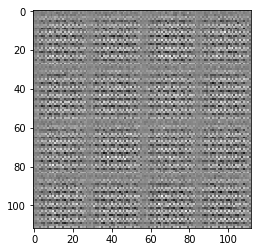

Epochs 1,batches 100, dis_loss 1.2199876308441162 , gen_loss1.0240464210510254
Epochs 1,batches 200, dis_loss 0.7643293738365173 , gen_loss1.7227810621261597
Epochs 1,batches 300, dis_loss 0.8928459882736206 , gen_loss1.1877646446228027
Epochs 1,batches 400, dis_loss 0.39354071021080017 , gen_loss3.5824763774871826
Epochs 1,batches 500, dis_loss 0.44463402032852173 , gen_loss3.790120840072632


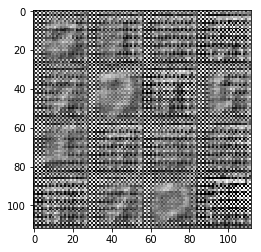

Epochs 2,batches 600, dis_loss 0.4046325385570526 , gen_loss4.619957447052002
Epochs 2,batches 700, dis_loss 0.3757988512516022 , gen_loss4.417792797088623
Epochs 2,batches 800, dis_loss 0.6620866656303406 , gen_loss2.7850701808929443
Epochs 2,batches 900, dis_loss 0.3596774935722351 , gen_loss4.603755474090576
Epochs 2,batches 1000, dis_loss 0.7390979528427124 , gen_loss1.612512230873108


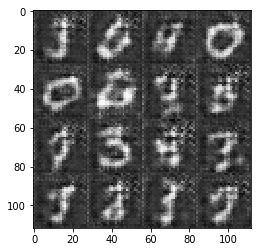

Epochs 3,batches 1100, dis_loss 0.7541866302490234 , gen_loss1.6483649015426636
Epochs 3,batches 1200, dis_loss 0.475483238697052 , gen_loss4.6845316886901855
Epochs 3,batches 1300, dis_loss 0.549441933631897 , gen_loss2.2656288146972656
Epochs 3,batches 1400, dis_loss 0.5682741403579712 , gen_loss2.9261953830718994
Epochs 3,batches 1500, dis_loss 0.4318860173225403 , gen_loss4.318034648895264


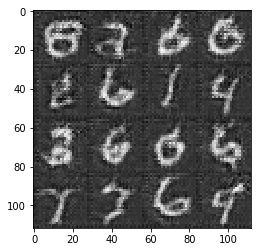

Epochs 4,batches 1600, dis_loss 0.5897708535194397 , gen_loss1.9710052013397217
Epochs 4,batches 1700, dis_loss 0.904050350189209 , gen_loss5.364618301391602
Epochs 4,batches 1800, dis_loss 0.7662521600723267 , gen_loss1.61976158618927
Epochs 4,batches 1900, dis_loss 0.6479032039642334 , gen_loss1.6603198051452637
Epochs 4,batches 2000, dis_loss 0.43495121598243713 , gen_loss3.184413194656372


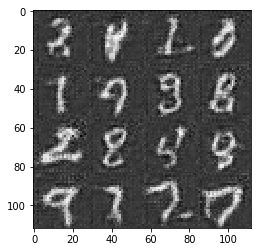

Epochs 5,batches 2100, dis_loss 0.5570800304412842 , gen_loss2.4689536094665527
Epochs 5,batches 2200, dis_loss 0.5852192640304565 , gen_loss3.256466865539551
Epochs 5,batches 2300, dis_loss 0.4850161075592041 , gen_loss2.9587948322296143
Epochs 5,batches 2400, dis_loss 0.5953647494316101 , gen_loss2.0686750411987305
Epochs 5,batches 2500, dis_loss 0.5750424265861511 , gen_loss2.7024128437042236


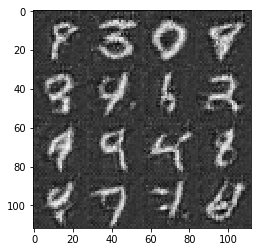

Epochs 6,batches 2600, dis_loss 0.6109926700592041 , gen_loss2.3414456844329834
Epochs 6,batches 2700, dis_loss 0.5245289206504822 , gen_loss2.8175811767578125
Epochs 6,batches 2800, dis_loss 0.5929477214813232 , gen_loss2.5411572456359863
Epochs 6,batches 2900, dis_loss 0.620606005191803 , gen_loss1.9005488157272339
Epochs 6,batches 3000, dis_loss 0.5750173926353455 , gen_loss2.635385751724243


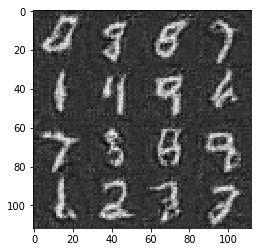

Epochs 7,batches 3100, dis_loss 0.4942984879016876 , gen_loss3.679508686065674
Epochs 7,batches 3200, dis_loss 0.626810610294342 , gen_loss3.0653305053710938
Epochs 7,batches 3300, dis_loss 0.48823970556259155 , gen_loss2.936422824859619
Epochs 7,batches 3400, dis_loss 0.4713813066482544 , gen_loss3.1880948543548584
Epochs 7,batches 3500, dis_loss 0.6067898273468018 , gen_loss2.6636667251586914


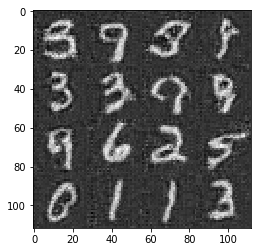

Epochs 8,batches 3600, dis_loss 0.6162850856781006 , gen_loss2.2978663444519043
Epochs 8,batches 3700, dis_loss 0.5499098896980286 , gen_loss3.4067060947418213
Epochs 8,batches 3800, dis_loss 0.5667471289634705 , gen_loss2.7820208072662354
Epochs 8,batches 3900, dis_loss 0.5995415449142456 , gen_loss3.7512941360473633
Epochs 8,batches 4000, dis_loss 0.7956644296646118 , gen_loss5.093713760375977


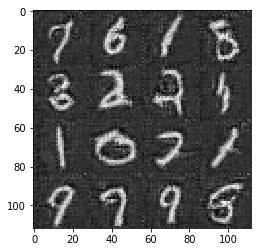

Epochs 9,batches 4100, dis_loss 0.695222020149231 , gen_loss2.481675624847412
Epochs 9,batches 4200, dis_loss 0.5463684797286987 , gen_loss2.6168746948242188
Epochs 9,batches 4300, dis_loss 0.769202709197998 , gen_loss1.8498361110687256
Epochs 9,batches 4400, dis_loss 0.5717437267303467 , gen_loss2.6359994411468506
Epochs 9,batches 4500, dis_loss 0.3907352685928345 , gen_loss5.180381774902344


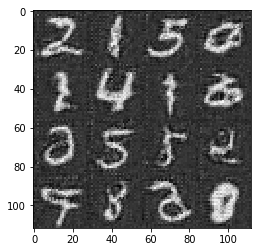

Epochs 10,batches 4600, dis_loss 0.7959820628166199 , gen_loss2.626969814300537
Epochs 10,batches 4700, dis_loss 0.5601122379302979 , gen_loss2.9364798069000244
Epochs 10,batches 4800, dis_loss 0.486538290977478 , gen_loss3.2682619094848633
Epochs 10,batches 4900, dis_loss 0.5440014004707336 , gen_loss2.2255163192749023
Epochs 10,batches 5000, dis_loss 0.48773351311683655 , gen_loss2.164789915084839


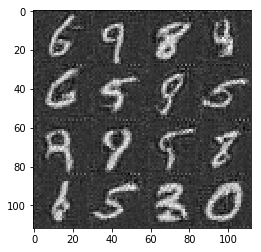

In [23]:
batch_size = 120
z_dim = 100
learning_rate = 0.001
beta1 = 0.7


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 10

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

initial output


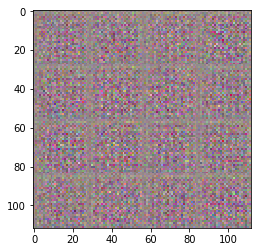

Epochs 1,batches 10, dis_loss 1.4978816509246826 , gen_loss0.8454743027687073
Epochs 1,batches 20, dis_loss 1.4456956386566162 , gen_loss0.8937331438064575
Epochs 1,batches 30, dis_loss 1.479856014251709 , gen_loss0.9015235304832458
Epochs 1,batches 40, dis_loss 1.4289231300354004 , gen_loss0.8247373104095459
Epochs 1,batches 50, dis_loss 1.4134221076965332 , gen_loss0.8893365263938904
Epochs 1,batches 60, dis_loss 1.4459240436553955 , gen_loss0.9006963968276978
Epochs 1,batches 70, dis_loss 1.4272222518920898 , gen_loss0.8927965760231018
Epochs 1,batches 80, dis_loss 1.3821848630905151 , gen_loss0.9458116292953491
Epochs 1,batches 90, dis_loss 1.3689112663269043 , gen_loss0.8741018772125244
Epochs 1,batches 100, dis_loss 1.3734865188598633 , gen_loss0.9387742877006531


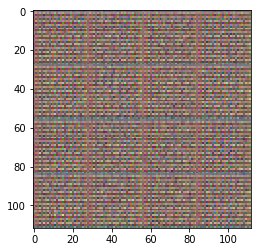

Epochs 1,batches 110, dis_loss 1.3532330989837646 , gen_loss0.9486770629882812
Epochs 1,batches 120, dis_loss 1.3103148937225342 , gen_loss0.9375076293945312
Epochs 1,batches 130, dis_loss 1.3063249588012695 , gen_loss1.033096432685852
Epochs 1,batches 140, dis_loss 1.249148964881897 , gen_loss0.9976904392242432
Epochs 1,batches 150, dis_loss 1.1870405673980713 , gen_loss1.0228891372680664
Epochs 1,batches 160, dis_loss 1.2026616334915161 , gen_loss1.0436201095581055
Epochs 1,batches 170, dis_loss 1.160097599029541 , gen_loss1.0891752243041992
Epochs 1,batches 180, dis_loss 1.103670358657837 , gen_loss1.0981473922729492
Epochs 1,batches 190, dis_loss 1.1080986261367798 , gen_loss1.176558017730713
Epochs 1,batches 200, dis_loss 1.0039526224136353 , gen_loss1.255764365196228


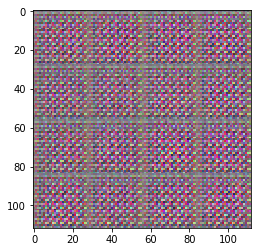

Epochs 1,batches 210, dis_loss 1.0896482467651367 , gen_loss1.2395319938659668
Epochs 1,batches 220, dis_loss 0.9973211884498596 , gen_loss1.2731372117996216
Epochs 1,batches 230, dis_loss 0.8955328464508057 , gen_loss1.369930624961853
Epochs 1,batches 240, dis_loss 1.043334722518921 , gen_loss1.2311193943023682
Epochs 1,batches 250, dis_loss 1.309444785118103 , gen_loss0.9322688579559326
Epochs 1,batches 260, dis_loss 1.3257031440734863 , gen_loss0.9393075704574585
Epochs 1,batches 270, dis_loss 1.469823956489563 , gen_loss0.8380758762359619
Epochs 1,batches 280, dis_loss 1.5468324422836304 , gen_loss0.8492147326469421
Epochs 1,batches 290, dis_loss 1.4470593929290771 , gen_loss0.8205451369285583
Epochs 1,batches 300, dis_loss 1.4769947528839111 , gen_loss0.7805658578872681


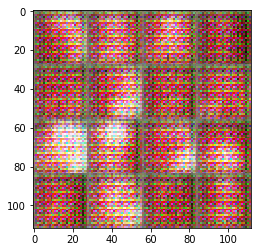

Epochs 1,batches 310, dis_loss 1.2943623065948486 , gen_loss0.756084144115448
Epochs 1,batches 320, dis_loss 1.4269880056381226 , gen_loss0.8393323421478271
Epochs 1,batches 330, dis_loss 1.4358090162277222 , gen_loss0.7700058817863464
Epochs 1,batches 340, dis_loss 1.384398102760315 , gen_loss0.8069288730621338
Epochs 1,batches 350, dis_loss 1.3659337759017944 , gen_loss0.7887832522392273
Epochs 1,batches 360, dis_loss 1.3722689151763916 , gen_loss0.864574134349823
Epochs 1,batches 370, dis_loss 1.3778514862060547 , gen_loss0.8835980892181396
Epochs 1,batches 380, dis_loss 1.2889659404754639 , gen_loss0.8779730200767517
Epochs 1,batches 390, dis_loss 1.310786247253418 , gen_loss0.8890335559844971
Epochs 1,batches 400, dis_loss 1.3558683395385742 , gen_loss0.8938543200492859


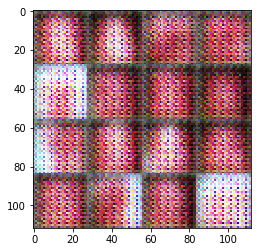

Epochs 1,batches 410, dis_loss 1.3517847061157227 , gen_loss0.9540379047393799
Epochs 1,batches 420, dis_loss 1.297706127166748 , gen_loss0.8485919833183289
Epochs 1,batches 430, dis_loss 1.260880470275879 , gen_loss0.9435530304908752
Epochs 1,batches 440, dis_loss 1.3677517175674438 , gen_loss0.8664403557777405
Epochs 1,batches 450, dis_loss 1.4184805154800415 , gen_loss0.7915134429931641
Epochs 1,batches 460, dis_loss 1.379807949066162 , gen_loss0.9058841466903687
Epochs 1,batches 470, dis_loss 1.3634145259857178 , gen_loss0.9040838479995728
Epochs 1,batches 480, dis_loss 1.3938043117523193 , gen_loss0.9150302410125732
Epochs 1,batches 490, dis_loss 1.4703361988067627 , gen_loss0.866355836391449
Epochs 1,batches 500, dis_loss 1.4255033731460571 , gen_loss0.9367449283599854


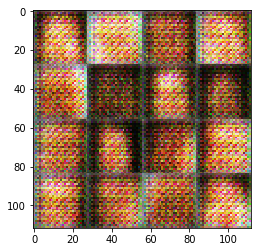

Epochs 1,batches 510, dis_loss 1.3610848188400269 , gen_loss0.8573787212371826
Epochs 1,batches 520, dis_loss 1.3146347999572754 , gen_loss0.8905269503593445
Epochs 1,batches 530, dis_loss 1.4303233623504639 , gen_loss0.9237333536148071
Epochs 1,batches 540, dis_loss 1.3772106170654297 , gen_loss0.8888269066810608
Epochs 1,batches 550, dis_loss 1.3370082378387451 , gen_loss0.8746727705001831
Epochs 1,batches 560, dis_loss 1.3053743839263916 , gen_loss0.9105648994445801
Epochs 1,batches 570, dis_loss 1.345063328742981 , gen_loss0.9044780135154724
Epochs 1,batches 580, dis_loss 1.3205914497375488 , gen_loss0.8929616808891296
Epochs 1,batches 590, dis_loss 1.3887295722961426 , gen_loss0.8990412354469299
Epochs 1,batches 600, dis_loss 1.3014435768127441 , gen_loss0.8836220502853394


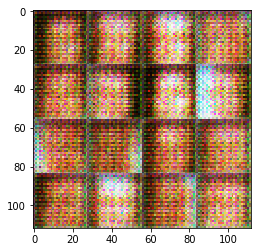

Epochs 1,batches 610, dis_loss 1.3364806175231934 , gen_loss0.9109151363372803
Epochs 1,batches 620, dis_loss 1.2356661558151245 , gen_loss0.9070015549659729
Epochs 1,batches 630, dis_loss 1.2516179084777832 , gen_loss0.9375735521316528
Epochs 1,batches 640, dis_loss 1.2932155132293701 , gen_loss0.9179298877716064
Epochs 1,batches 650, dis_loss 1.2339856624603271 , gen_loss0.9388008117675781
Epochs 1,batches 660, dis_loss 1.2960231304168701 , gen_loss0.9260457754135132
Epochs 1,batches 670, dis_loss 1.281574010848999 , gen_loss0.9911141991615295
Epochs 1,batches 680, dis_loss 1.1527493000030518 , gen_loss1.033896803855896
Epochs 1,batches 690, dis_loss 1.2493460178375244 , gen_loss0.9728542566299438
Epochs 1,batches 700, dis_loss 1.336714267730713 , gen_loss0.9629504680633545


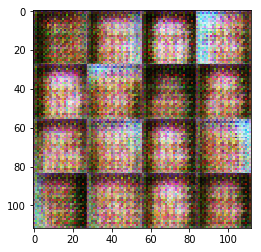

Epochs 1,batches 710, dis_loss 1.3326642513275146 , gen_loss1.0019742250442505
Epochs 1,batches 720, dis_loss 1.2540196180343628 , gen_loss0.9970853328704834
Epochs 1,batches 730, dis_loss 1.229543924331665 , gen_loss1.0548977851867676
Epochs 1,batches 740, dis_loss 1.1939294338226318 , gen_loss1.0359869003295898
Epochs 1,batches 750, dis_loss 1.2599341869354248 , gen_loss0.9448376297950745
Epochs 1,batches 760, dis_loss 1.2173466682434082 , gen_loss1.006670594215393
Epochs 1,batches 770, dis_loss 1.1992805004119873 , gen_loss1.0078521966934204
Epochs 1,batches 780, dis_loss 1.1733801364898682 , gen_loss0.9656966924667358
Epochs 1,batches 790, dis_loss 1.1816449165344238 , gen_loss1.0476794242858887
Epochs 1,batches 800, dis_loss 1.1667587757110596 , gen_loss1.1586121320724487


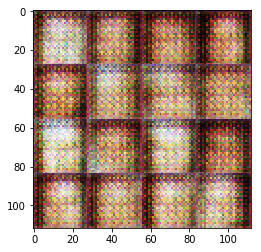

Epochs 1,batches 810, dis_loss 1.2053762674331665 , gen_loss1.116828203201294
Epochs 1,batches 820, dis_loss 1.2236809730529785 , gen_loss1.1248607635498047
Epochs 1,batches 830, dis_loss 1.0923269987106323 , gen_loss1.072116494178772
Epochs 1,batches 840, dis_loss 1.2754465341567993 , gen_loss1.1662869453430176
Epochs 1,batches 850, dis_loss 1.1647509336471558 , gen_loss1.1448091268539429
Epochs 1,batches 860, dis_loss 1.1391432285308838 , gen_loss1.1257760524749756
Epochs 1,batches 870, dis_loss 1.1756105422973633 , gen_loss1.2084544897079468
Epochs 1,batches 880, dis_loss 1.1623997688293457 , gen_loss1.1626896858215332
Epochs 1,batches 890, dis_loss 1.042549729347229 , gen_loss1.228543758392334
Epochs 1,batches 900, dis_loss 1.0715302228927612 , gen_loss1.2332097291946411


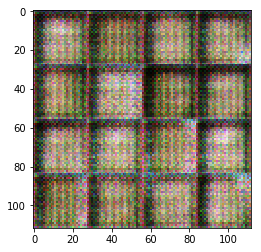

Epochs 1,batches 910, dis_loss 1.0198732614517212 , gen_loss1.262141227722168
Epochs 1,batches 920, dis_loss 1.0753815174102783 , gen_loss1.155264973640442
Epochs 1,batches 930, dis_loss 1.1335008144378662 , gen_loss1.235274314880371
Epochs 1,batches 940, dis_loss 1.0287590026855469 , gen_loss1.1947544813156128
Epochs 1,batches 950, dis_loss 1.1492809057235718 , gen_loss1.1455470323562622
Epochs 1,batches 960, dis_loss 1.0139271020889282 , gen_loss1.1982402801513672
Epochs 1,batches 970, dis_loss 1.086668848991394 , gen_loss1.244265079498291
Epochs 1,batches 980, dis_loss 1.0345960855484009 , gen_loss1.2176655530929565
Epochs 1,batches 990, dis_loss 1.0868602991104126 , gen_loss1.3021330833435059
Epochs 1,batches 1000, dis_loss 1.014858603477478 , gen_loss1.2392351627349854


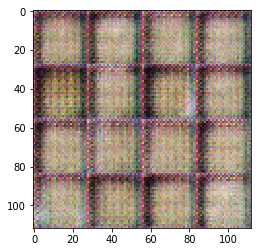

Epochs 1,batches 1010, dis_loss 0.9458416700363159 , gen_loss1.1796053647994995
Epochs 1,batches 1020, dis_loss 1.0362745523452759 , gen_loss1.2666095495224
Epochs 1,batches 1030, dis_loss 1.0334676504135132 , gen_loss1.3057469129562378
Epochs 1,batches 1040, dis_loss 1.005198359489441 , gen_loss1.2507331371307373
Epochs 1,batches 1050, dis_loss 1.089972734451294 , gen_loss1.385745882987976
Epochs 1,batches 1060, dis_loss 1.0273641347885132 , gen_loss1.1897497177124023
Epochs 1,batches 1070, dis_loss 1.1016737222671509 , gen_loss1.1974003314971924
Epochs 1,batches 1080, dis_loss 1.1161447763442993 , gen_loss1.1788973808288574
Epochs 1,batches 1090, dis_loss 1.0931859016418457 , gen_loss1.2144346237182617
Epochs 1,batches 1100, dis_loss 1.0854219198226929 , gen_loss1.3958079814910889


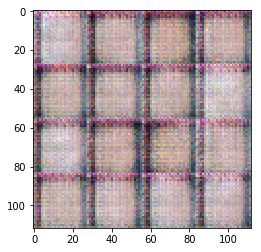

Epochs 1,batches 1110, dis_loss 1.1838072538375854 , gen_loss1.1537851095199585
Epochs 1,batches 1120, dis_loss 1.1564216613769531 , gen_loss1.3260537385940552
Epochs 1,batches 1130, dis_loss 1.0192444324493408 , gen_loss1.1310771703720093
Epochs 1,batches 1140, dis_loss 1.1108152866363525 , gen_loss1.096820592880249
Epochs 1,batches 1150, dis_loss 1.066957950592041 , gen_loss1.1719743013381958
Epochs 1,batches 1160, dis_loss 1.129350185394287 , gen_loss1.1726157665252686
Epochs 1,batches 1170, dis_loss 1.147230863571167 , gen_loss1.1461231708526611
Epochs 1,batches 1180, dis_loss 1.19476318359375 , gen_loss1.1904617547988892
Epochs 1,batches 1190, dis_loss 0.9857197999954224 , gen_loss1.1879570484161377
Epochs 1,batches 1200, dis_loss 1.1497160196304321 , gen_loss1.1413516998291016


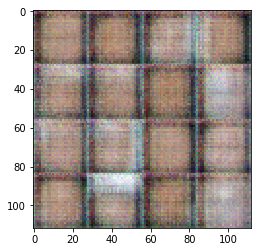

Epochs 1,batches 1210, dis_loss 1.090486764907837 , gen_loss1.2055131196975708
Epochs 1,batches 1220, dis_loss 1.0203766822814941 , gen_loss1.0420751571655273
Epochs 1,batches 1230, dis_loss 1.0401294231414795 , gen_loss1.2342568635940552


In [ ]:
batch_size = 100
z_dim = 100
learning_rate = 0.0001
beta1 = 0.8


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.